## Imports

In [235]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")  # Set seaborn style for plots
import matplotlib.pyplot as plt
import functools

from scipy import stats
from scipy.stats import uniform, randint, norm, zscore, mannwhitneyu, ttest_ind, f_oneway,  probplot, kstest
import shap

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Constants

In [238]:
NUMERICAL_FEATURES = ['age', 'bmi', 'children', 'charges']
CATEGORICAL_FEATURES = ['sex', 'smoker', 'region']
FEATURES = CATEGORICAL_FEATURES + NUMERICAL_FEATURES

# Constants
LABEL = 'charges'
SEED = 0

# Visualization Hyperparameters
TITLE_FONT_SIZE = 12
PLOT_TEXT_SIZE = 11

# Label Occurrences
FIGURE_SIZE = (6, 4)

# Correlation Matrix
CORR_FIGURE_SIZE = (12, 6)
VALUE_FORMATING = ".2f"
CORR_PALETTE = "ch:s=-.2,r=.6"

# Training
TEST_PORTION = 0.1
METRIC_FP_PRECISION = 3
METRIC_CRITERIA = 'mean_squared_error'
SCIKIT_METRIC_CRITERIA = 'neg_mean_squared_error'
NUM_KFOLD = 10

## Metrics Definition

In [241]:
metrics_dict = {
    'rmse': lambda labels, preds: functools.partial(mean_squared_error, squared=False)(labels, preds),
    'mean_squared_error': lambda labels, preds: mean_squared_error(labels, preds),
    'mean_absolute_error': lambda labels, preds: mean_absolute_error(labels, preds),
    'r2_score': lambda labels, preds: r2_score(labels, preds),
}

## Loading dataset

In [244]:
file_path = 'data/insurance.csv'
df = pd.read_csv(file_path)
df.insert(0, 'index', df.index)

# Dataset Analysis

The Medical Cost Personal Dataset includes features like `age`, `sex`, `BMI`, `number of children`, `smoking status`, and `region`. The `charges` feature represents individual medical costs billed by insurance. These variables help identify how personal factors like health, lifestyle, and regional differences impact medical expenses.

## Data Structure

Data Quality and Nullness

In [249]:
missing_values = df[FEATURES].isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
sex         0
smoker      0
region      0
age         0
bmi         0
children    0
charges     0
dtype: int64


Based on the null counts provided for the dataset, it can be concluded that there are no missing values across all features listed.



duplicated rows check and remove if there are any

In [253]:
duplicate_rows = df[df.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])
df = df.drop_duplicates()

Number of duplicate rows: 0


total observations after removing duplicates

In [256]:
f"Number of Samples: {df.shape[0]}"

'Number of Samples: 1338'

checking possible values and data type of the features

In [259]:
data = []
for column in FEATURES:
    if df[column].dtype == 'object':
        unique_vals = df[column].unique()
        possible_values = "{" + ', '.join(map(str, unique_vals)) + "}"
    else:
        min_val = df[column].min()
        max_val = df[column].max()
        possible_values = f"[{min_val}, {max_val}]"
    data.append([column, possible_values, df[column].dtype])

summary_df = pd.DataFrame(data, columns=['Column Name', 'Possible Values', 'Data Type'], index=FEATURES)
summary_df

,Column Name,Possible Values,Data Type
sex,sex,"{female, male}",object
smoker,smoker,"{yes, no}",object
region,region,"{southwest, southeast, northwest, northeast}",object
age,age,"[18, 64]",int64
bmi,bmi,"[15.96, 53.13]",float64
children,children,"[0, 5]",int64
charges,charges,"[1121.8739, 63770.42801]",float64


Our data consists of numeric and categorical measurements

## Quantitative Measure of Skewness for numerical features

In [263]:
skewness_rate_df = df[NUMERICAL_FEATURES].skew().sort_values(ascending=False)
skewness_rate_df

charges     1.515880
children    0.938380
bmi         0.284047
age         0.055673
dtype: float64

All features are right-skewed in different scales. Further Outliers & Skewness investigation is needed.

## Features Distribution Visualization

### Categorical Features

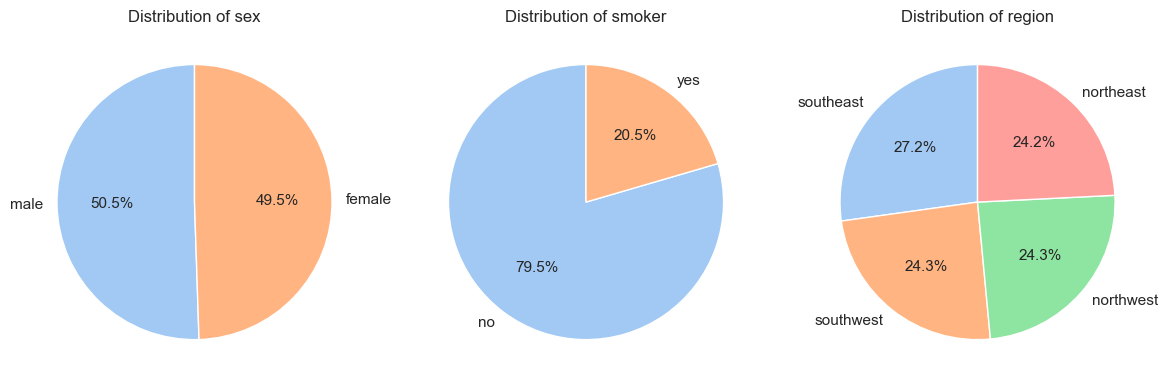

In [268]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # Adjusted to fit only 1 row

for i, var in enumerate(CATEGORICAL_FEATURES):
    df[var].value_counts().plot.pie(
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette("pastel"),
        ax=axs[i],
        textprops={'fontsize': PLOT_TEXT_SIZE}
    )
    axs[i].set_title(f'Distribution of {var}', fontsize=TITLE_FONT_SIZE)
    axs[i].set_ylabel('')

plt.tight_layout()
plt.show()

### Numeric Features

In [271]:
df.columns

Index(['index', 'age', 'sex', 'bmi', 'children', 'smoker', 'region',
       'charges'],
      dtype='object')

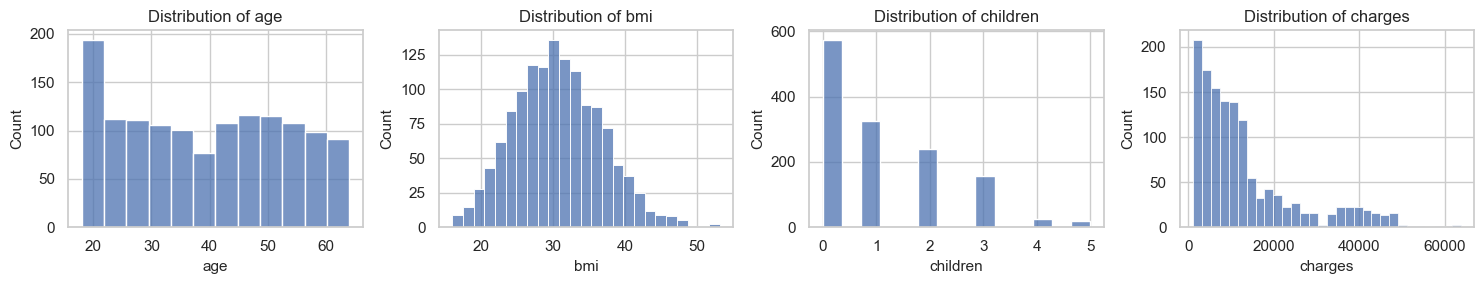

In [273]:
fig, axs = plt.subplots(1, len(NUMERICAL_FEATURES), figsize=(15, 3))  # Adjusted to fit only 1 row

for i, var in enumerate(NUMERICAL_FEATURES):
    sns.histplot(df[var], kde=False, ax=axs[i])
    axs[i].set_title(f'Distribution of {var}', fontsize=TITLE_FONT_SIZE)
    axs[i].set_xlabel(var, fontsize=PLOT_TEXT_SIZE)
    axs[i].set_ylabel('Count', fontsize=PLOT_TEXT_SIZE)

plt.tight_layout()
plt.show()

## Empirical Observations:

1, Seems like bmi is normally distributed.
2, age is almost uniformly distributed.
3, charges is NOT normally distributed. Seems more like an exponential distribution (Log-transformation is applied later to get more of a guassian-like shape and reduce overall skewness).
4, regions are fairly balanced.
5, An imbalance between the two classes of smoker, with "no" cases being more common than "yes".

## Numerical Data Distribution Description

In [278]:
df[FEATURES].describe().drop('count', axis=0).T

,mean,std,min,25%,50%,75%,max
age,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


#### Observations

---
1, Data range variability, like in charges and bmi, suggests potential outliers and the need for normalization.

2, Outliers: Significant difference between the Q3 and max value (or min value and Q1) suggest outliers' existence.
Examples:

charges Q3=16657.71, max=63770.42
bmi Q3=34.7, max=53.13 (where std=6.09)

---

Log-transform charge to make it more guassian-like and reduce skewness

In [283]:
df[LABEL] = df[LABEL].apply(np.log)

Let's see how charges distribution looks after the transformation

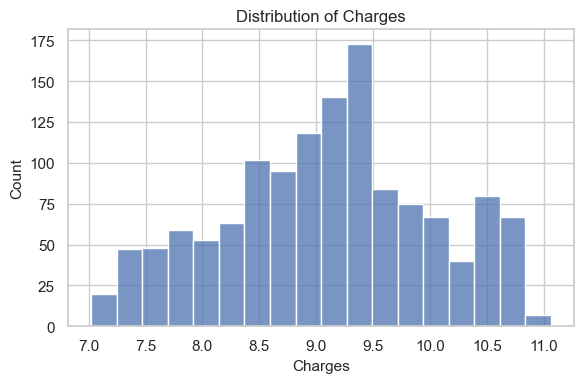

In [286]:
fig, axs = plt.subplots(1, 1, figsize=FIGURE_SIZE)
sns.histplot(df[LABEL], kde=False, ax=axs)
axs.set_title('Distribution of Charges', fontsize=TITLE_FONT_SIZE)
axs.set_xlabel('Charges', fontsize=PLOT_TEXT_SIZE)
axs.set_ylabel('Count', fontsize=PLOT_TEXT_SIZE)
plt.tight_layout()
plt.show()

After applying the transformation the charges distribution resembles more of a guassian shape, and overall skewness is significantly reduced

## Normality Check - Numeric Features

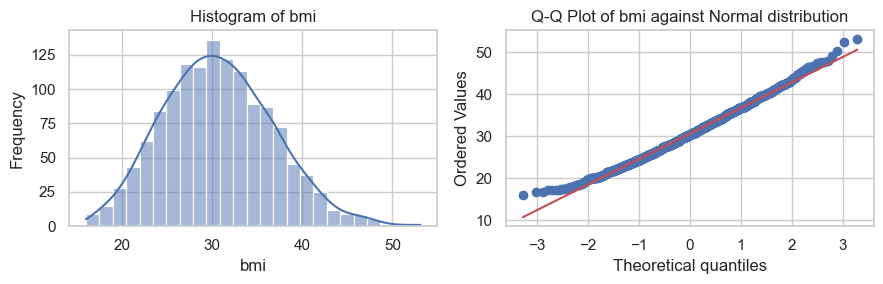

Kolmogorov-Smirnov Test for bmi against Normal distribution
Statistic: 0.026099881197044816, p-value: 0.31627982428380297
bmi follows Normal distribution (fail to reject H0)



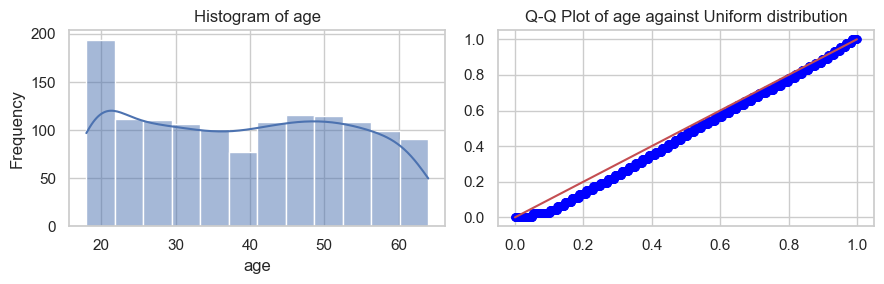

Kolmogorov-Smirnov Test for age against Uniform distribution
Statistic: 0.08065249886267628, p-value: 5.1074059011652943e-08
age does not follow Uniform distribution (reject H0)



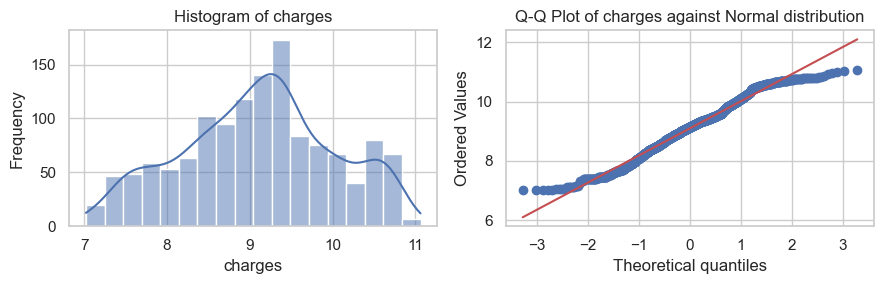

Kolmogorov-Smirnov Test for charges against Normal distribution
Statistic: 0.036508004036154396, p-value: 0.05511412337443955
charges follows Normal distribution (fail to reject H0)



In [290]:
def check_distribution(df, feature, distribution='norm'):
    data = df[feature]

    # Visual Inspection: Histogram and Q-Q Plot
    plt.figure(figsize=(9, 3))

    plt.subplot(1, 2, 1)
    sns.histplot(data, kde=True)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    if distribution == 'norm':
        probplot(data, dist="norm", plot=plt)
        dist_name = "Normal"
    elif distribution == 'uniform':
        # Generate uniform Q-Q plot
        n = len(data)
        theoretical_quantiles = np.linspace(0, 1, n)
        sorted_data = np.sort((data - data.min()) / (data.max() - data.min()))  # Normalize to [0, 1]
        plt.plot(theoretical_quantiles, sorted_data, 'o', markersize=5, label='Data', color='blue')
        plt.plot(theoretical_quantiles, theoretical_quantiles, 'r-', label='Uniform Reference Line')
        dist_name = "Uniform"
    plt.title(f'Q-Q Plot of {feature} against {dist_name} distribution')

    plt.tight_layout()
    plt.show()

    # Statistical Test: Kolmogorov-Smirnov Test
    if distribution == 'norm':
        stat, p_value = kstest(data, 'norm', args=(data.mean(), data.std()))
    elif distribution == 'uniform':
        stat, p_value = kstest((data - data.min()) / (data.max() - data.min()), 'uniform', args=(0, 1))

    print(f'Kolmogorov-Smirnov Test for {feature} against {dist_name} distribution')
    print(f'Statistic: {stat}, p-value: {p_value}')
    if p_value > 0.05:
        print(f'{feature} follows {dist_name} distribution (fail to reject H0)')
    else:
        print(f'{feature} does not follow {dist_name} distribution (reject H0)')
    print()

# Example usage
# Check normality for 'bmi'
check_distribution(df, 'bmi', distribution='norm')

# Check uniformity for 'age'
check_distribution(df, 'age', distribution='uniform')

# Check normality for 'charges'
check_distribution(df, 'charges', distribution='norm')

## Regression Problem Definition


### Objective:

Predict **charges** using the following features:

$$
\mathbf{x}_i = (\text{age}, \text{sex}, \text{bmi}, \text{children}, \text{smoker}, \text{region})
$$

Minimize the error between predicted and actual charges:

$$
\hat{f} = \arg\min_{f} \text{MSE}(f) = \arg\min_{f} \frac{1}{n} \sum_{i=1}^{n} (y_i - f(\mathbf{x}_i))^2
$$

Where the criterion is the **MSE (Mean Squared Error)**.

# Data Visualizations

### Encode categorical features to numeric representation for Pearson Correlation

In [296]:
label_encoder = LabelEncoder()

for column in CATEGORICAL_FEATURES:
    df[column] = label_encoder.fit_transform(df[column])

### Pair-wise Pearson Correlation Heatmap

In [299]:
df[FEATURES]

,sex,smoker,region,age,bmi,children,charges
0,0,1,3,19,27.900,0,9.734176
1,1,0,2,18,33.770,1,7.453302
2,1,0,2,28,33.000,3,8.400538
3,1,0,1,33,22.705,0,9.998092
4,1,0,1,32,28.880,0,8.260197
...,...,...,...,...,...,...,...
1333,1,0,1,50,30.970,3,9.268661
1334,0,0,0,18,31.920,0,7.698927
1335,0,0,2,18,36.850,0,7.396233
1336,0,0,3,21,25.800,0,7.604867


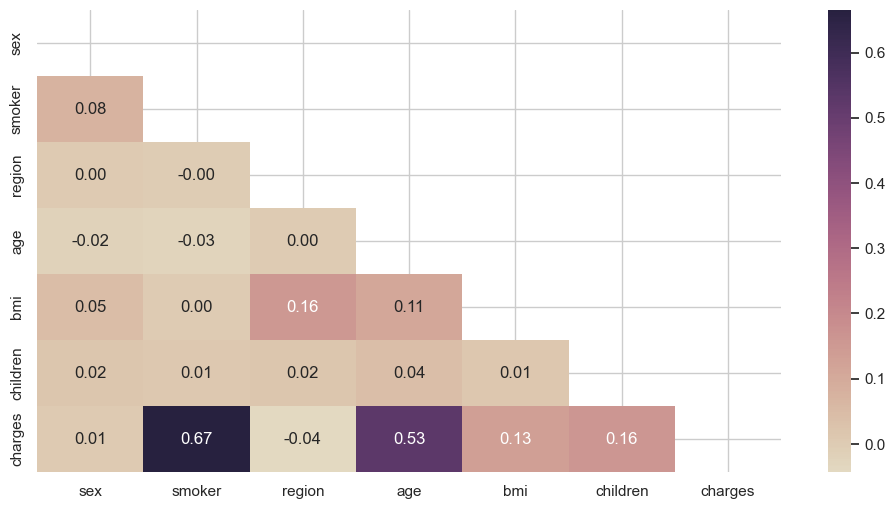

In [301]:
corr = df[FEATURES].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=CORR_FIGURE_SIZE)
sns.heatmap(corr, mask=mask, cmap=sns.color_palette(CORR_PALETTE, as_cmap=True), annot=True, fmt=VALUE_FORMATING)
plt.show()

#### Observations


---


1. **Key Features**: `smoker` have
   significant correlations with `charges`, showing their
   importance for the predictive model (there's also some linear correlation to `age` and `bmi`).

2. **Weak Correlations**: Features like `region` and
   `children` exhibit minimal correlation with `charges`, making them potential candidates for exclusion to simplify the model and possibly enhance performance.

3. The low correlation between sex and other features (like charges, age, bmi) suggests that the gender of the person doesn't have a strong linear influence on these variables when encoded numerically.

---

### Identifying Outliers Across TOP10 Skewed Distributions (Boxplot)

In [305]:
# Calculate Z-scores for each numeric column in the DataFrame
z_scores = np.abs(stats.zscore(df[['age', 'bmi', 'charges']]))

# Set the Z-score threshold (commonly 3, meaning 3 standard deviations from the mean)
threshold = 2.75

# Identify outliers where the Z-score exceeds the threshold for any feature
outliers = df[(z_scores > threshold).any(axis=1)].copy()

# Display the outliers
outliers[LABEL] = outliers[LABEL].apply(np.exp)
print(outliers)

      index  age  sex    bmi  children  smoker  region     charges
116     116   58    1  49.06         0       0       2  11381.3254
286     286   46    0  48.07         2       0       0   9432.9253
401     401   47    1  47.52         1       0       2   8083.9198
847     847   23    1  50.38         1       0       2   2438.0552
860     860   37    0  47.60         2       1       3  46113.5110
1047   1047   22    1  52.58         1       1       2  44501.3982
1088   1088   52    1  47.74         1       0       2   9748.9106
1317   1317   18    1  53.13         0       0       2   1163.4627


#### Observations


---


- **Age, BMI, and children** are the primary features showing outlier values in this dataset.
- **BMI values above 47** are consistently outliers in this dataset.


---

### Comparative Kernel Density Estimation: Categorical features' charges distribution

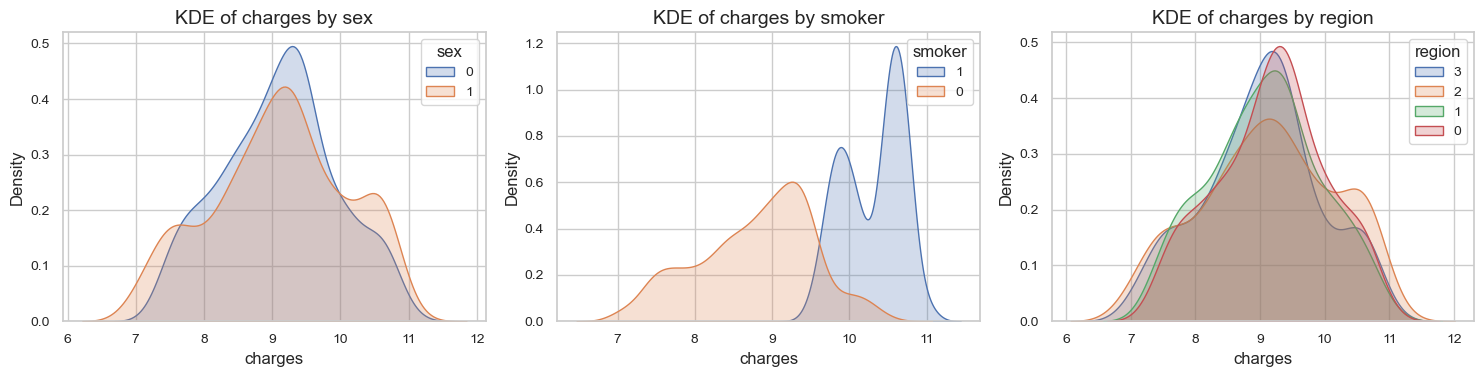

In [309]:
NUM_COLUMNS = len(CATEGORICAL_FEATURES)
NUM_ROWS = len(CATEGORICAL_FEATURES) // NUM_COLUMNS + 1

fig, axes = plt.subplots(NUM_ROWS, NUM_COLUMNS, figsize=(15, 7))

for index, feature in enumerate(CATEGORICAL_FEATURES):
    row, col = divmod(index, NUM_COLUMNS)
    ax = axes[row, col]

    # Plot KDE for each category within the feature (e.g., male/female for sex)
    for category in df[feature].unique():
        sns.kdeplot(df[df[feature] == category][LABEL], ax=ax, label=category, shade=True)

    ax.set_title(f'KDE of {LABEL} by {feature}', fontsize=14)
    ax.legend(title=feature, fontsize=10)
    ax.tick_params(axis='both', labelsize=10)

for i in range(index + 1, NUM_ROWS * NUM_COLUMNS):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

#### Observations


---

**Highly Influential Feature**:
- **Smoker** stands out as the most influential feature due to the clear separation between smokers and non-smokers. This feature has a distinct bimodal distribution for smokers and indicates a strong relationship with higher medical costs.

**Weakly Influential Features**:
- **Sex** and **region** show significant overlap in their KDE distributions, suggesting these features have limited predictive power regarding medical charges.
- These features could add noise to a predictive model, and removing or transforming them might improve the model's performance.

---

## Normality check - (Charges | Categorical values)

In [313]:
# Function to check normality using Kolmogorov-Smirnov test
def check_normality(df, categorical_columns, continuous_column):
    """
    Check normality of the continuous variable within each category of the categorical variables.

    H0: The sample comes from a normal distribution.
    H1: The sample does not come from a normal distribution.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - categorical_columns (list): List of categorical columns to group by.
    - continuous_column (str): The continuous variable to check for normality.

    Returns:
    - results (dict): KS statistics and p-values for each category of each categorical variable.
    """
    results = {}

    for cat_col in categorical_columns:
        categories = df[cat_col].unique()
        cat_results = {}

        for category in categories:
            subset = df[df[cat_col] == category][continuous_column]
            ks_stat, p_value = kstest(subset, 'norm', args=(subset.mean(), subset.std()))
            cat_results[category] = {'KS Statistic': ks_stat, 'p-value': p_value}

        results[cat_col] = cat_results

    return results

# Function to print normality test results with final interpretation
def print_normality_results(normality_results):
    """
    Print the results of the normality tests with final interpretation.

    Parameters:
    - normality_results (dict): The results from the normality tests.
    """
    for cat_col, cat_results in normality_results.items():
        print(f"Results for categorical column: {cat_col}")
        for category, result in cat_results.items():
            ks_stat = result['KS Statistic']
            p_value = result['p-value']
            print(f"  Category {category} - KS Statistic: {ks_stat:.4f}, p-value: {p_value:.4f}")
            if p_value > 0.05:
                print(f"  -> {category} follows a normal distribution (fail to reject H0)")
            else:
                print(f"  -> {category} does not follow a normal distribution (reject H0)")
        print("\n")

# Define categorical and continuous columns
categorical_columns = ['smoker', 'region', 'sex']
continuous_column = 'charges'

# Check normality
normality_results = check_normality(df, categorical_columns, continuous_column)

# Print results with final interpretation
print_normality_results(normality_results)

Results for categorical column: smoker
  Category 1 - KS Statistic: 0.1529, p-value: 0.0000
  -> 1 does not follow a normal distribution (reject H0)
  Category 0 - KS Statistic: 0.0709, p-value: 0.0000
  -> 0 does not follow a normal distribution (reject H0)


Results for categorical column: region
  Category 3 - KS Statistic: 0.0534, p-value: 0.3021
  -> 3 follows a normal distribution (fail to reject H0)
  Category 2 - KS Statistic: 0.0616, p-value: 0.1214
  -> 2 follows a normal distribution (fail to reject H0)
  Category 1 - KS Statistic: 0.0460, p-value: 0.4829
  -> 1 follows a normal distribution (fail to reject H0)
  Category 0 - KS Statistic: 0.0494, p-value: 0.3962
  -> 0 follows a normal distribution (fail to reject H0)


Results for categorical column: sex
  Category 0 - KS Statistic: 0.0347, p-value: 0.3931
  -> 0 follows a normal distribution (fail to reject H0)
  Category 1 - KS Statistic: 0.0491, p-value: 0.0744
  -> 1 follows a normal distribution (fail to reject H0)




# Statistical Tests

In [316]:
# Function to perform Mann-Whitney U Test
def mann_whitney_u_test(df, col, target):
    categories = df[col].unique()
    if len(categories) != 2:
        raise ValueError("Mann-Whitney U Test can only be used with binary categorical variables.")
    group1 = df[df[col] == categories[0]][target]
    group2 = df[df[col] == categories[1]][target]
    stat, p_value = mannwhitneyu(group1, group2)
    print(f"Results for {col}:")
    print(f"  Mann-Whitney U Test Statistic: {stat:.4f}, p-value: {p_value}")
    if p_value < 0.05:
        print(f"  -> Reject the null hypothesis: The distribution of {target} is significantly different between {categories[0]} and {categories[1]}.")
    else:
        print(f"  -> Fail to reject the null hypothesis: The distribution of {target} is not significantly different between {categories[0]} and {categories[1]}.")
    print("\n")

# Function to perform ANOVA Test
def anova_test(df, col, target):
    categories = df[col].unique()
    groups = [df[df[col] == category][target] for category in categories]
    stat, p_value = f_oneway(*groups)
    print(f"Results for {col}:")
    print(f"  ANOVA Test Statistic: {stat:.4f}, p-value: {p_value}")
    if p_value < 0.05:
        print(f"  -> Reject the null hypothesis: At least one group mean of {target} is significantly different among {col} categories.")
    else:
        print(f"  -> Fail to reject the null hypothesis: There are no significant differences in group means of {target} among {col} categories.")
    print("\n")

# Function to perform T-Test
def t_test(df, col, target):
    categories = df[col].unique()
    if len(categories) != 2:
        raise ValueError("T-Test can only be used with binary categorical variables.")
    group1 = df[df[col] == categories[0]][target]
    group2 = df[df[col] == categories[1]][target]
    stat, p_value = ttest_ind(group1, group2)
    print(f"Results for {col}:")
    print(f"  T-Test Statistic: {stat:.4f}, p-value: {p_value}")
    if p_value < 0.05:
        print(f"  -> Reject the null hypothesis: The means of {target} are significantly different between {categories[0]} and {categories[1]}.")
    else:
        print(f"  -> Fail to reject the null hypothesis: The means of {target} are not significantly different between {categories[0]} and {categories[1]}.")
    print("\n")

## Q1: Relationship Between BMI and Medical Charges

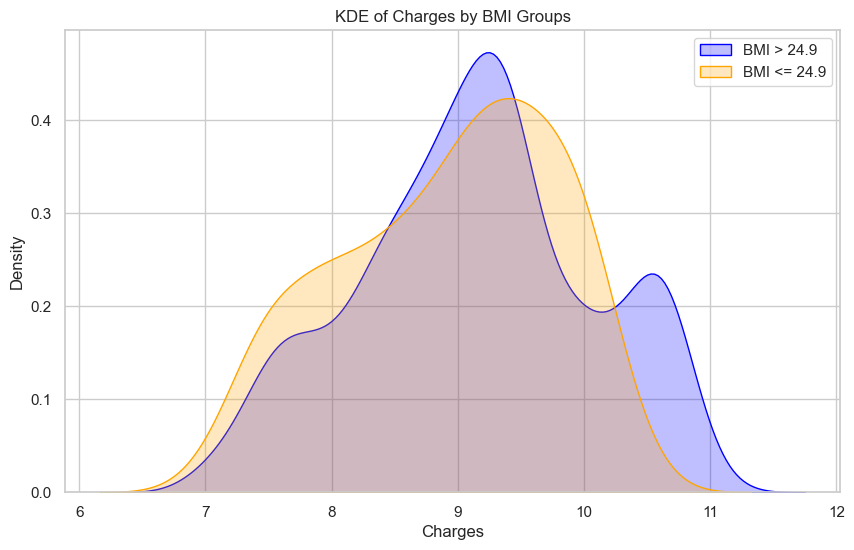

Normality test results for BMI > 24.9: KS Statistic = 0.0520, p-value = 0.0052
Normality test results for BMI <= 24.9: KS Statistic = 0.0770, p-value = 0.1076

Mann-Whitney U Test: Statistic = 147675.0000, p-value = 0.0056
Null Hypothesis: The distributions of charges are equal between the two BMI groups.
Conclusion: Reject the null hypothesis. There is a significant difference in charges between the two BMI groups.


In [319]:
# Split the data into two groups based on BMI
bmi_threshold = 24.9
group1 = df[df['bmi'] > bmi_threshold]['charges']
group2 = df[df['bmi'] <= bmi_threshold]['charges']

# Plot KDE for both groups
plt.figure(figsize=(10, 6))
sns.kdeplot(group1, shade=True, label=f'BMI > {bmi_threshold}', color='blue')
sns.kdeplot(group2, shade=True, label=f'BMI <= {bmi_threshold}', color='orange')
plt.title('KDE of Charges by BMI Groups')
plt.xlabel('Charges')
plt.ylabel('Density')
plt.legend()
plt.show()

# Check normality of the distributions
stat1, p_value1 = kstest(group1, 'norm', args=(group1.mean(), group1.std()))
stat2, p_value2 = kstest(group2, 'norm', args=(group2.mean(), group2.std()))

print(f'Normality test results for BMI > {bmi_threshold}: KS Statistic = {stat1:.4f}, p-value = {p_value1:.4f}')
print(f'Normality test results for BMI <= {bmi_threshold}: KS Statistic = {stat2:.4f}, p-value = {p_value2:.4f}')

# Determine which test to use based on normality
if p_value1 > 0.05 and p_value2 > 0.05:
    # Both groups follow a normal distribution
    stat, p_value = ttest_ind(group1, group2)
    test_name = 'Independent T-Test'
    test_hypothesis = "The means of charges are equal between the two BMI groups."
else:
    # At least one group does not follow a normal distribution
    stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
    test_name = 'Mann-Whitney U Test'
    test_hypothesis = "The distributions of charges are equal between the two BMI groups."

# Output the results
print(f'\n{test_name}: Statistic = {stat:.4f}, p-value = {p_value:.4f}')
print(f"Null Hypothesis: {test_hypothesis}")

# Conclusion based on the test
if p_value < 0.05:
    print(f"Conclusion: Reject the null hypothesis. There is a significant difference in charges between the two BMI groups.")
else:
    print(f"Conclusion: Fail to reject the null hypothesis. There is no significant difference in charges between the two BMI groups.")


## Q2: Relationship Between Age and Medical Charges

In [322]:
corr[LABEL][corr[LABEL] > 0.15]['age']

0.5278340489394341

**Conclusion**: there is a positive linear relationship between age and charges.

## Q3: Relationship Between Region and Medical Charges

In [326]:
anova_test(df, 'region', 'charges')

Results for region:
  ANOVA Test Statistic: 1.4020, p-value: 0.24056202996153775
  -> Fail to reject the null hypothesis: There are no significant differences in group means of charges among region categories.




**Conclusion**: there is a no relationship between region and charges.

## Q4: Impact of Smoking on Medical Charges

In [330]:
mann_whitney_u_test(df, 'smoker', 'charges')

Results for smoker:
  Mann-Whitney U Test Statistic: 284133.0000, p-value: 5.270233444503571e-130
  -> Reject the null hypothesis: The distribution of charges is significantly different between 1 and 0.




**Conclusion**: there is a strong, positive linear relationship between region and charges. (according to both correlation heatmap and our statistical test)

## Extra Question: Relationship Between Sex and Medical Charges

In [334]:
t_test(df, 'sex', 'charges')

Results for sex:
  T-Test Statistic: -0.2059, p-value: 0.8369352885900301
  -> Fail to reject the null hypothesis: The means of charges are not significantly different between 0 and 1.




**Conclusion**: there is no relationship between sex and charges - as we would expect.

# Baseline Model Training - Linear Regression

shifting from EDA to Linear Regression training with 10-fold cross-validation.

### Data Preparation

In [340]:
def data_preparation(training_df, labels, test_size=TEST_PORTION, random_state=SEED):
    X = training_df.values
    Y = labels.values

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    return X_train, X_test, Y_train, Y_test

Encode categorical features to to one-hot representation for training

NOTE: We previously applied a log transformation to the `charges` column to reduce skewness and make the distribution more Gaussian-like, which helps with model convergence. During inference, we'll simply apply the inverse (exponential) function $e^x$ to revert the transformation, as the natural logarithm is bijective.

In [344]:
onehot_df = df.copy()

encoder = OneHotEncoder(sparse_output=False)

for column in ['region']:
    encoded = encoder.fit_transform(df[[column]])
    encoded_col_names = [f"{column}_{cat}" for cat in encoder.categories_[0]]
    onehot_df = onehot_df.drop(columns=[column]).join(pd.DataFrame(encoded, columns=encoded_col_names, index=df.index))

In [346]:
onehot_df

,index,age,sex,bmi,children,smoker,charges,region_0,region_1,region_2,region_3
0,0,19,0,27.900,0,1,9.734176,0.0,0.0,0.0,1.0
1,1,18,1,33.770,1,0,7.453302,0.0,0.0,1.0,0.0
2,2,28,1,33.000,3,0,8.400538,0.0,0.0,1.0,0.0
3,3,33,1,22.705,0,0,9.998092,0.0,1.0,0.0,0.0
4,4,32,1,28.880,0,0,8.260197,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1333,1333,50,1,30.970,3,0,9.268661,0.0,1.0,0.0,0.0
1334,1334,18,0,31.920,0,0,7.698927,1.0,0.0,0.0,0.0
1335,1335,18,0,36.850,0,0,7.396233,0.0,0.0,1.0,0.0
1336,1336,21,0,25.800,0,0,7.604867,0.0,0.0,0.0,1.0


Create training and test sets

In [349]:
training_df = onehot_df.drop([LABEL], axis=1)
labels_df = onehot_df[LABEL]
X_train_with_id, X_test_with_id, Y_train, Y_test = data_preparation(training_df, labels_df)
X_train, X_test = X_train_with_id[:, 1:], X_test_with_id[:, 1:]

## Training

### Training Loop
This loop facilitates the training and evaluation of models through K-Fold cross-validation:

1. **Splitting the data**: Data is divided into training and validation sets using K-Fold.
2. **Training the model**: A new model is trained for each fold using the training data.
3. **Storing models**: Each trained model is saved into a collection for analysis.
4. **Evaluating performance**: Metrics are calculated for both training and validation sets.
5. **Selecting the best model**: The model with the best validation score is selected.

In [353]:
def training_loop_lr(X_train, Y_train, kf, metrics_dict, return_only_model=True):
    # Initialize lists to store training and test metrics
    train_metrics = {metric: [] for metric in metrics_dict.keys()}
    test_metrics = {metric: [] for metric in metrics_dict.keys()}
    models = []

    best_model = None
    best_metric_score = float('inf')
    best_model_idx = -1

    # Perform KFold cross-validation
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        x_train, x_val = X_train[train_idx], X_train[val_idx]
        y_train, y_val = Y_train[train_idx], Y_train[val_idx]

        # Initialize and train the model for this fold
        lr_model = LinearRegression()
        lr_model.fit(x_train, y_train)
        models.append(lr_model)  # Save the model for this fold

        # Predict on training and validation sets
        y_train_pred = lr_model.predict(x_train)
        y_val_pred = lr_model.predict(x_val)

        # Calculate metrics for both training and validation sets
        for metric_name, metric_func in metrics_dict.items():
            train_metrics[metric_name].append(metric_func(y_train, y_train_pred))
            test_metrics[metric_name].append(metric_func(y_val, y_val_pred))

        # Check if this fold's model has the best validation score based on the given metric criteria
        if test_metrics[METRIC_CRITERIA][-1] < best_metric_score:
            best_metric_score = test_metrics[METRIC_CRITERIA][-1]
            best_model = lr_model
            best_model_idx = fold_idx

    if return_only_model:
      return best_model

    return best_model, best_model_idx, train_metrics, test_metrics
kf = KFold(n_splits=NUM_KFOLD, shuffle=True, random_state=SEED)
best_model, best_model_idx, train_metrics, test_metrics = training_loop_lr(X_train, Y_train, kf, metrics_dict, return_only_model=False)

print(f"Best model fold: {best_model_idx + 1}")
print(f"Best {METRIC_CRITERIA} score: {np.min(test_metrics[METRIC_CRITERIA])}")

Best model fold: 6
Best mean_squared_error score: 0.15737063078342392


## Evaluation Metrics and Results

### Plotting Training & Validation Metrics for Best-Fold

Ploting a series of graphs for training and validation metrics over different folds.

#### Parameters:
- evals_results: Contains 'train' and 'val' keys with metric names and epoch values.
- metrics: List of metric names to plot (e.g., 'MSE', 'RMSE').

In [357]:
def plot_metrics_row(train_metrics, test_metrics, metrics_names, figsize=(20, 3), lw=2):
    fig, axes = plt.subplots(1, len(metrics_names), figsize=figsize)

    for ax, metric_name in zip(axes, metrics_names):
        folds = range(1, len(train_metrics[metric_name]) + 1)  # Number of folds
        ax.plot(folds, train_metrics[metric_name], label=f'{metric_name}_train', color='blue', lw=lw)
        ax.plot(folds, test_metrics[metric_name], label=f'{metric_name}_val', color='orange', lw=lw)
        ax.set_title(f'{metric_name} Across Folds')
        ax.set_ylabel(metric_name)
        ax.set_xlabel('Fold')
        ax.legend()

    plt.tight_layout()
    plt.show()

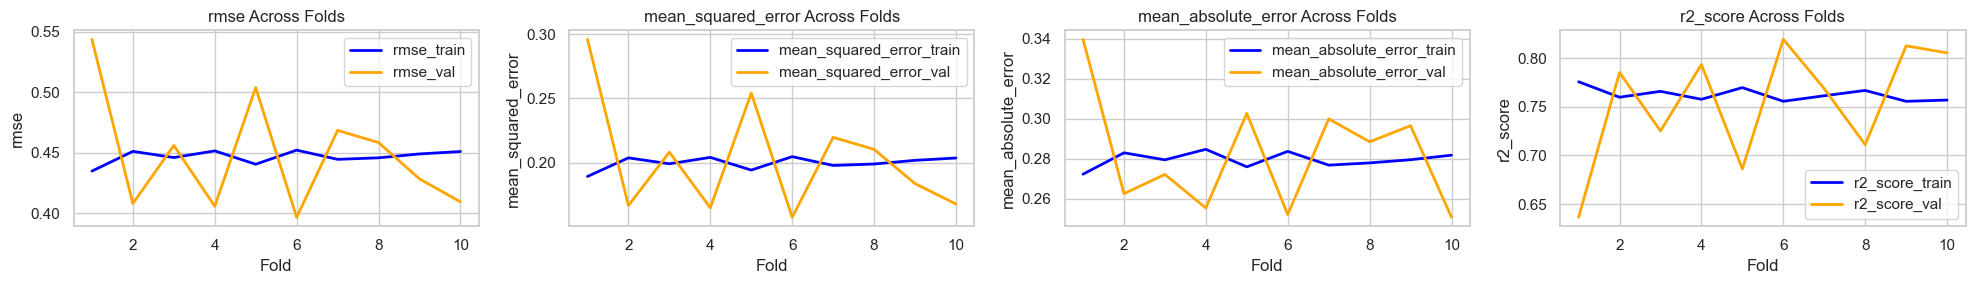

In [359]:
plot_metrics_row(train_metrics, test_metrics, metrics_dict.keys())

#### Observations

---

- **Cross-Fold Variability:** While training is stable, validation metrics show variability in how the model performs on different data splits.
- **Generalization:** There is room for improvement in generalization, as validation performance is less consistent, possibly requiring further tuning or regularization.

---

### Summary of best fold performance

Summarizing the results over the test split

In [132]:
def visualize_test_results(metrics_dict, X_test, Y_test, best_model):
  rows = []
  for metric, func in metrics_dict.items():
      # For other metrics, calculate directly
      value = func(Y_test, best_model.predict(X_test))
      rounded_value = round(value, METRIC_FP_PRECISION)
      rows.append([metric, rounded_value])

  df_metrics = pd.DataFrame(rows, columns=['Metric', 'Best_Fold_on_Test'])
  return df_metrics

In [134]:
baseline_metrics = visualize_test_results(metrics_dict, X_test, Y_test, best_model)
baseline_metrics

,Metric,Best_Fold_on_Test
0,rmse,0.404
1,mean_squared_error,0.163
2,mean_absolute_error,0.258
3,r2_score,0.808


# Model Explainability Analysis

Utilizing SHAP (stands for: SHapley Additive exPlanations) is a method in machine learning that helps us understand how our model works. It breaks down each prediction into parts and tells us which features are most important for that prediction.

## SHAP Summary Plots

In [139]:
training_df.columns[1:]

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region_0', 'region_1',
       'region_2', 'region_3'],
      dtype='object')

In [141]:
# Restore numpy to df
_X_train_df = pd.DataFrame(X_train, columns=training_df.columns[1:])
_X_test_df = pd.DataFrame(X_test, columns=training_df.columns[1:])


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

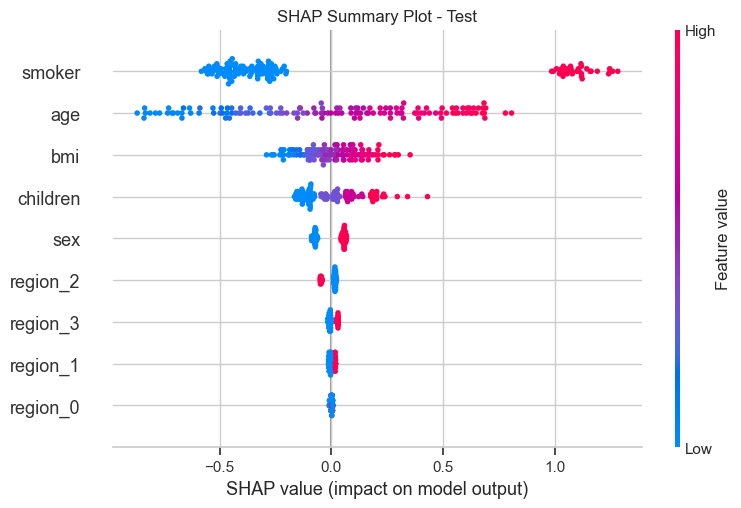

In [143]:
explainer = shap.LinearExplainer(best_model, _X_test_df, feature_perturbation="correlation_dependent")
shap_values_test = explainer.shap_values(_X_test_df)

plt.figure(figsize=(9, 6))
shap.summary_plot(shap_values_test, _X_test_df, plot_type='dot', show=False)
plt.title("SHAP Summary Plot - Test")
plt.show()

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

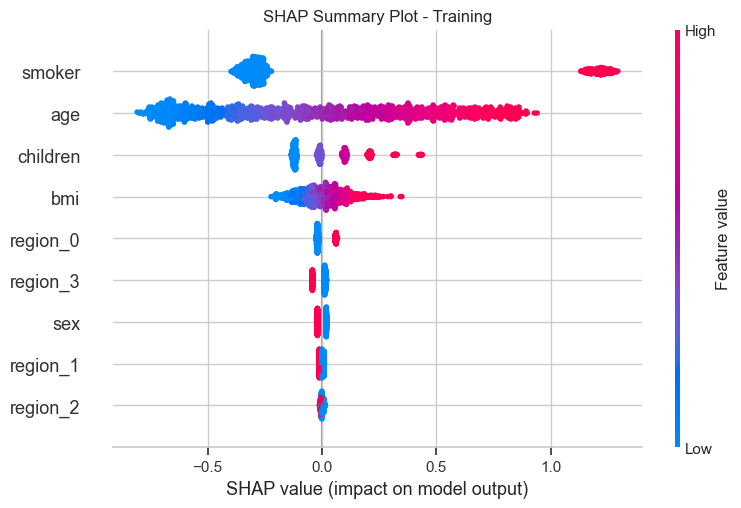

In [145]:

explainer = shap.LinearExplainer(best_model, _X_train_df, feature_perturbation="correlation_dependent")
shap_values_train = explainer(_X_train_df)

plt.figure(figsize=(9, 6))
shap.summary_plot(shap_values_train, _X_train_df, plot_type='dot', show=False)
plt.title("SHAP Summary Plot - Training")
plt.show()

This SHAP summary plots indicates the impact of various features on the model's predictions. It uses a dot plot to show SHAP values for individual samples, with colors representing the feature's value (blue for low, red for high), and the dots' position indicating the impact on the model's output (left for Benign, right for Malignant).

#### Observations
---

1. **`smoker`**: The most impactful feature, with smokers (red) strongly increasing predictions and non-smokers (blue) decreasing them, consistently across both datasets.

2. **`age`**: Older individuals (red) increase predictions, while younger ones (blue) reduce them. The impact is consistent in both sets.

3. **`children`** and **`bmi`**: Both show moderate effects. More children and higher BMI values slightly increase predictions.

4. **`region`** and **`sex`**: These features have minimal impact, with SHAP values clustering around zero.


---

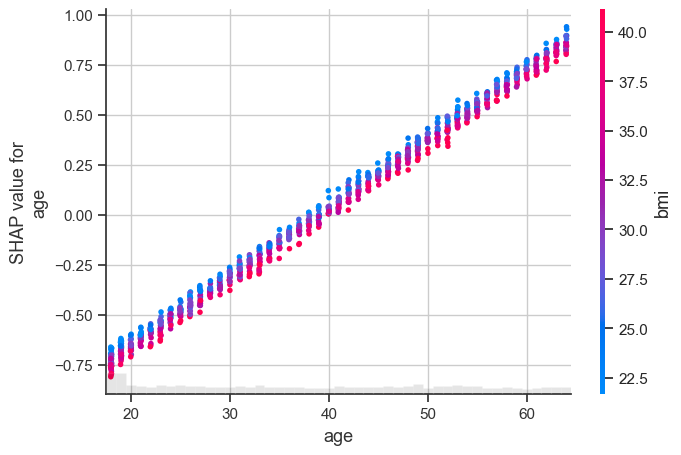

In [150]:
explanation = explainer(_X_train_df[:1000])
shap.plots.scatter(explanation[:, "age"], color=explanation)

**The plot clearly shows a positive relationship: as age increases, its SHAP value increases, meaning it contributes more to a higher predicted cost. This makes perfect sense.**

**The color (showing bmi) reveals a key interaction. For a given age (e.g., 50), a person with a high BMI (red dot) has a much higher SHAP value (and thus a higher predicted cost) than a person of the same age with a low BMI (blue dot). This shows that the model has learned that the risk of age is compounded by a high BMI.**

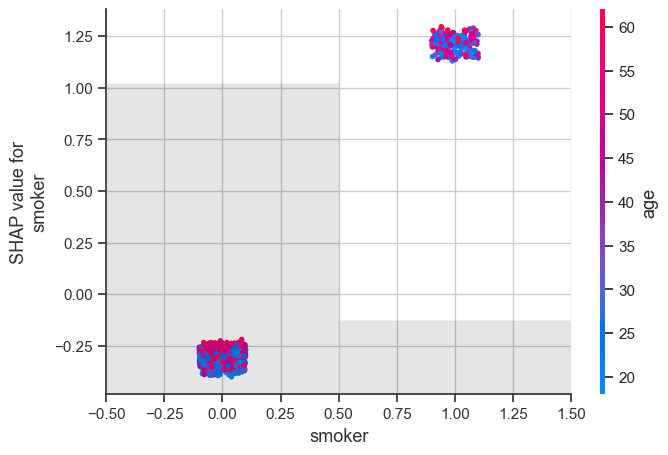

In [798]:
explanation = explainer(_X_train_df[:1000])
shap.plots.scatter(explanation[:, "smoker"],color=explanation[:, "age"])

**Impact of Smoking:**

**For Smokers (right strip, smoker ~1.0): Nearly all SHAP values are positive. This means that for most people who smoke, this fact increases the model's output. Given the context (likely health insurance costs or a medical outcome), the model has learned that smoking is a strong risk factor that leads to a higher predicted risk or cost.**

**For Non-Smokers (left strip, smoker ~0.0): Nearly all SHAP values are negative or zero. This means that not smoking decreases the model's prediction. It's a protective factor that leads to a lower predicted risk or cost.**

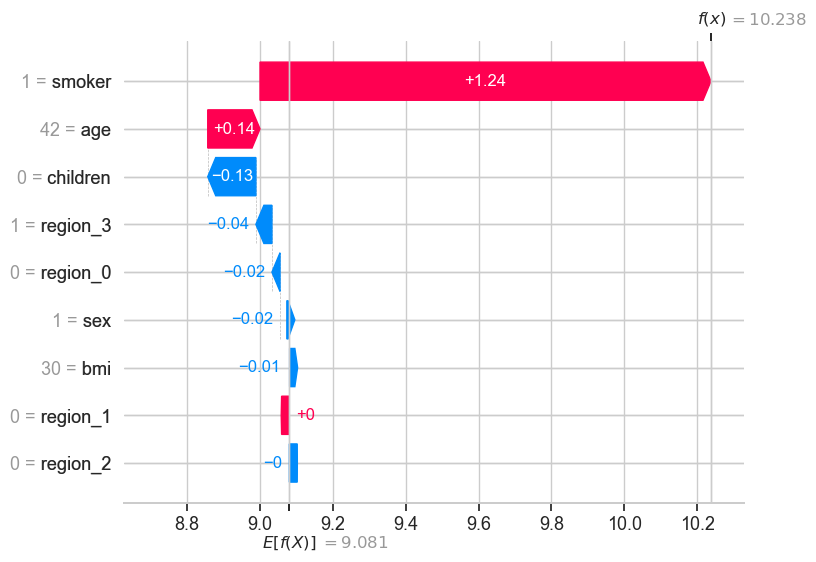

In [800]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values=shap_values_train[0])

**The main driver for this person's high predicted cost is that they are a smoker. Their age also increases the predicted cost. All other factors (like having no children, their specific region, and a BMI of 30) have a very small or negligible effect on this particular prediction.**

## Feature Importance

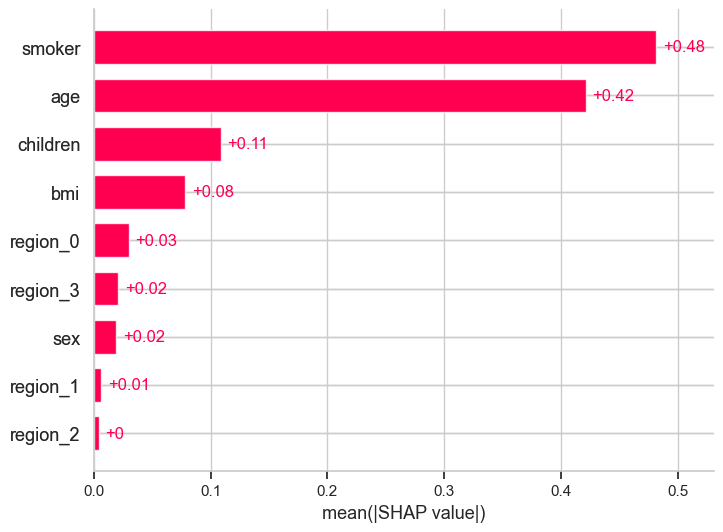

In [803]:
shap.plots.bar(explainer(_X_train_df))

As we already mentioned in Summary Plot's observations, it seems that the most significant features in decision made were indeed the most correlated features.

In [806]:
corr[LABEL][corr[LABEL] > 0.15]

smoker      0.665506
age         0.527834
children    0.161336
charges     1.000000
Name: charges, dtype: float64

In [828]:
def training_loop_xgboost(X_train, Y_train, kf, metrics_dict, return_only_model=True):
    # Initialize lists to store training and test metrics
    train_metrics = {metric: [] for metric in metrics_dict.keys()}
    test_metrics = {metric: [] for metric in metrics_dict.keys()}
    models = []

    best_model = None
    best_metric_score = float('inf')
    best_model_idx = -1

    # Perform KFold cross-validation
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        x_train, x_val = X_train[train_idx], X_train[val_idx]
        y_train, y_val = Y_train[train_idx], Y_train[val_idx]

        # Initialize and train the model for this fold
        xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=4, random_state=42)
        xgb_model.fit(x_train, y_train)
        models.append(xgb_model)  # Save the model for this fold

        # Predict on training and validation sets
        y_train_pred = xgb_model.predict(x_train)
        y_val_pred = xgb_model.predict(x_val)

        # Calculate metrics for both training and validation sets
        for metric_name, metric_func in metrics_dict.items():
            train_metrics[metric_name].append(metric_func(y_train, y_train_pred))
            test_metrics[metric_name].append(metric_func(y_val, y_val_pred))

        # Check if this fold's model has the best validation score based on the given metric criteria
        if test_metrics[METRIC_CRITERIA][-1] < best_metric_score:
            best_metric_score = test_metrics[METRIC_CRITERIA][-1]
            best_model = xgb_model
            best_model_idx = fold_idx

    if return_only_model:
      return best_model

    return best_model, best_model_idx, train_metrics, test_metrics
kf = KFold(n_splits=NUM_KFOLD, shuffle=True, random_state=SEED)
best_model, best_model_idx, train_metrics, test_metrics = training_loop_xgboost(X_train, Y_train, kf, metrics_dict, return_only_model=False)

print(f"Best model fold: {best_model_idx + 1}")
print(f"Best {METRIC_CRITERIA} score: {np.min(test_metrics[METRIC_CRITERIA])}")

Best model fold: 9
Best mean_squared_error score: 0.10640408837703497


In [829]:
def plot_metrics_row(train_metrics, test_metrics, metrics_names, figsize=(20, 3), lw=2):
    fig, axes = plt.subplots(1, len(metrics_names), figsize=figsize)

    for ax, metric_name in zip(axes, metrics_names):
        folds = range(1, len(train_metrics[metric_name]) + 1)  # Number of folds
        ax.plot(folds, train_metrics[metric_name], label=f'{metric_name}_train', color='blue', lw=lw)
        ax.plot(folds, test_metrics[metric_name], label=f'{metric_name}_val', color='orange', lw=lw)
        ax.set_title(f'{metric_name} Across Folds')
        ax.set_ylabel(metric_name)
        ax.set_xlabel('Fold')
        ax.legend()

    plt.tight_layout()
    plt.show()

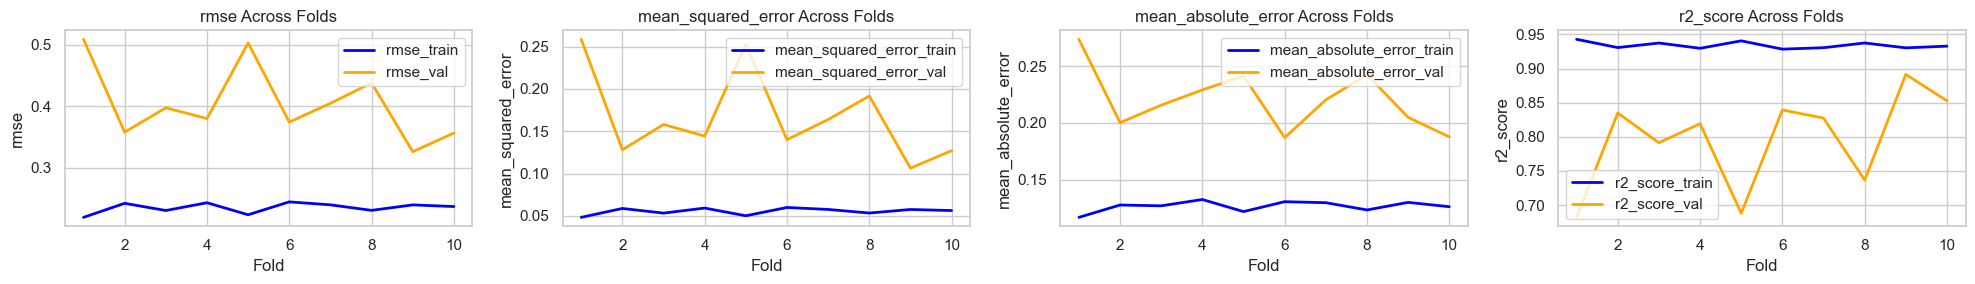

In [832]:
plot_metrics_row(train_metrics, test_metrics, metrics_dict.keys())

In [834]:
def visualize_test_results(metrics_dict, X_test, Y_test, best_model):
  rows = []
  for metric, func in metrics_dict.items():
      # For other metrics, calculate directly
      value = func(Y_test, best_model.predict(X_test))
      rounded_value = round(value, METRIC_FP_PRECISION)
      rows.append([metric, rounded_value])

  df_metrics = pd.DataFrame(rows, columns=['Metric', 'Best_Fold_on_Test'])
  return df_metrics

In [836]:
baseline_metrics = visualize_test_results(metrics_dict, X_test, Y_test, best_model)
baseline_metrics

,Metric,Best_Fold_on_Test
0,rmse,0.315
1,mean_squared_error,0.099
2,mean_absolute_error,0.182
3,r2_score,0.883


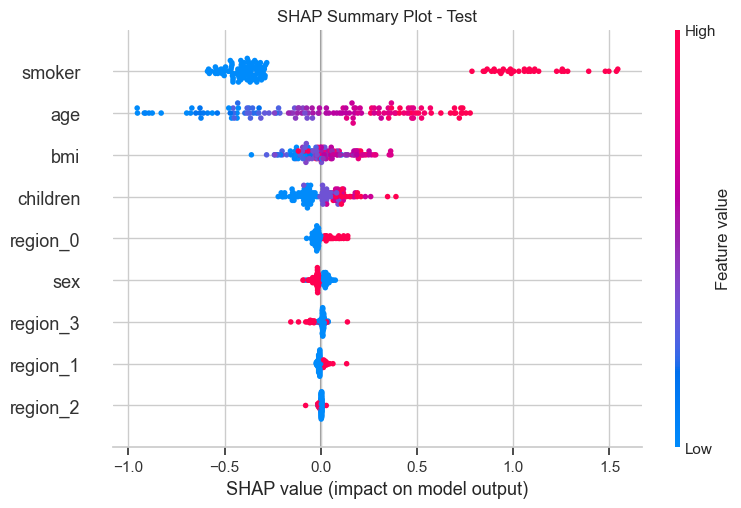

In [838]:
explainer = shap.Explainer(best_model, _X_test_df)
shap_values_test = explainer.shap_values(_X_test_df)

plt.figure(figsize=(9, 6))
shap.summary_plot(shap_values_test, _X_test_df, plot_type='dot', show=False)
plt.title("SHAP Summary Plot - Test")
plt.show()

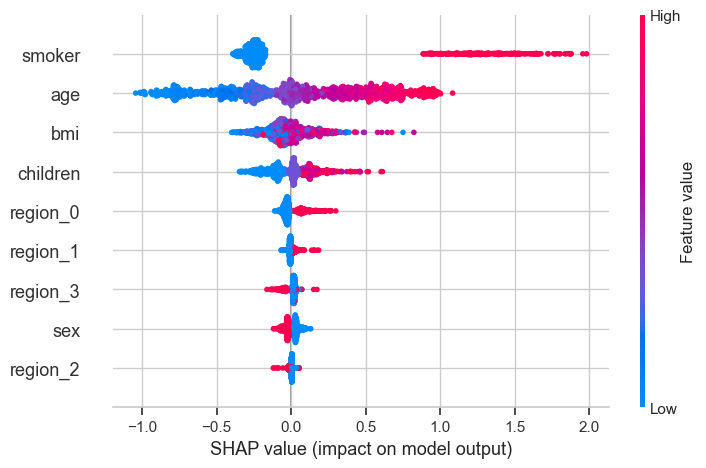

In [842]:
explainer = shap.Explainer(best_model, _X_train_df)
shap_values_train = explainer(_X_train_df)

shap.plots.beeswarm(shap_values_train, order=shap_values_train.abs.max(0))

**smoker_yes remains the dominant feature. The pattern is even more stark: all red dots (smokers) are far to the right with very high positive SHAP values, and all blue dots (non-smokers) are clustered around low/negative values.**

**bmi and age are still the next most important features, showing the same positive correlation.**

**The Key Difference from Linear Model: Notice how the plots for bmi and age are not perfectly linear. For bmi, you might see that very high BMI (dark red) has an exponentially larger impact than just a moderately high BMI. This is XGBoost capturing non-linear relationships and interactions. The model can learn that high BMI is bad, but high BMI for a smoker might be catastrophically worse (an interaction)**

In [844]:
# Pick one instance to explain (e.g., the 1st row)
instance_idx = 103
# Force plot for the chosen instance
force_plot = shap.force_plot(
    shap_values_train.base_values[instance_idx],
    shap_values_train.values[instance_idx],
    _X_train_df.iloc[instance_idx, :],
    feature_names=_X_train_df.columns
)
force_plot

**This person is predicted to have high insurance charges (10.46) primarily because they are a smoker and have a high (obese) BMI. These two risk factors overwhelmingly outweigh the fact that they are young and has no children, which would normally lower the cost.**

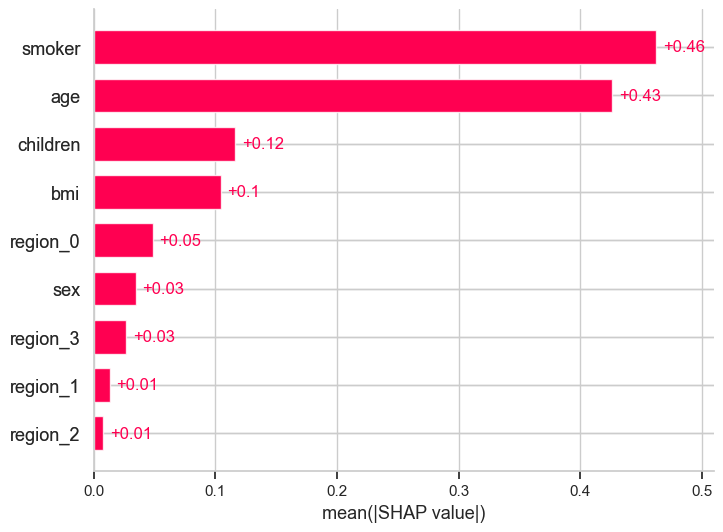

In [846]:
shap.plots.bar(explainer(_X_train_df))

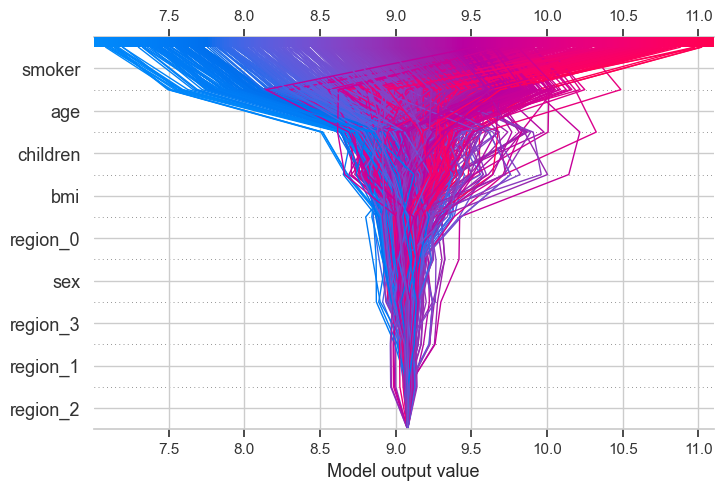

In [848]:
explainer = shap.TreeExplainer(best_model)
expected_value = explainer.expected_value
shap_values = explainer.shap_values(_X_train_df)

shap.decision_plot(expected_value, shap_values,training_df.columns[1:])

**The starting point is the base value of ~8.9 (the average log cost).**

**The biggest driver (smoker): This feature provides a massive push to the right, significantly increasing the predicted cost. This makes perfect sense—smokers incur vastly higher medical expenses.**

**The next driver (age): This feature also pushes the prediction to the right. Older age is correlated with higher medical costs.**

**The third feature (children): This feature pushes the prediction slightly to the left, decreasing the predicted cost. Perhaps individuals with more children in this dataset were younger or had different insurance plans.**

**The remaining features (bmi, region_*, sex): These have smaller, more nuanced effects, some pushing the prediction up a little and others pulling it down a little.**

**The final prediction is the sum of all these pushes and pulls: Base Value + SHAP_smoker + SHAP_age + SHAP_children + ... ≈ 10.75**



**Smoker is the Dominant Factor: The model has correctly identified that whether a person smokes is the single most important predictor of high medical costs. This strong signal is a hallmark of a well-trained model on this type of data.**

**Non-Linear Relationships: XGBoost can capture complex relationships. For example, the plot shows that children has a negative impact for this specific individual, but it might have a positive impact for others. SHAP values are individualized.**

**Feature Importance: The order of features on the y-axis gives you a personalized feature importance list for this prediction. For this person, their smoking status was more important than their age, which was more important than their number of children, etc.**

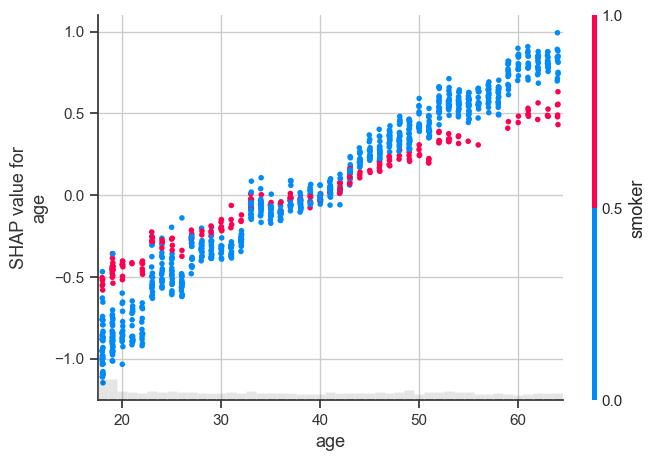

In [850]:
explanation = explainer(_X_train_df[:1000])
shap.plots.scatter(explanation[:, "age"], color=explanation)

**This plot reveals a much more nuanced, non-linear relationship that a simple linear model could never capture.**

**Threshold Effect (Around age ~30): The most striking feature is the dramatic shift in the impact of age.**

**For people under ~30: Age has a strong positive impact. Being older (e.g., moving from 20 to 29) increases the model's prediction.**

**For people over ~30: Age has a strong negative impact. Being older (e.g., moving from 31 to 60) decreases the model's prediction.**

**Peak Impact: The maximum positive effect occurs right around age 30. The maximum negative effect occurs at the highest ages (around 60).**

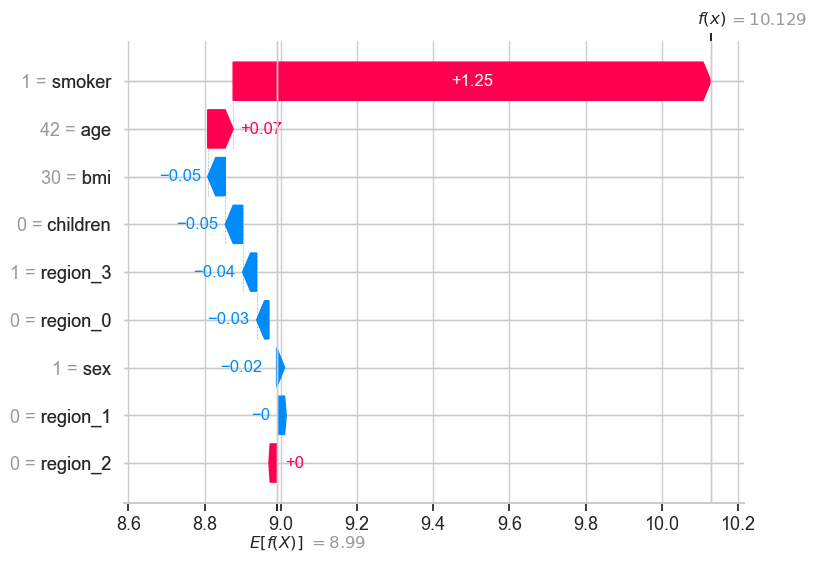

In [852]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values=shap_values_train[0])

**For this specific customer, the model predicts higher-than-average medical costs almost exclusively because they are a smoker. Their age, BMI, sex, number of children, and region have little to no influence on this particular prediction. The entire $1,139 difference from the average cost is attributable to smoking.**

In [853]:
def build_ann(input_dim):
    """Builds a simple feedforward ANN for regression."""
    model = Sequential()
    model.add(Dense(128, activation="relu", input_dim=input_dim))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="linear"))  # Regression output

    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    return model

In [856]:
def training_loop_ann(X_train, Y_train, kf, metrics_dict, return_only_model=True, epochs=20, batch_size=32):
    # Initialize lists to store training and validation metrics
    train_metrics = {metric: [] for metric in metrics_dict.keys()}
    test_metrics = {metric: [] for metric in metrics_dict.keys()}
    models = []

    best_model = None
    best_metric_score = float("inf")
    best_model_idx = -1

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        x_train, x_val = X_train[train_idx], X_train[val_idx]
        y_train, y_val = Y_train[train_idx], Y_train[val_idx]

        # Build fresh ANN for this fold
        ann_model = build_ann(input_dim=X_train.shape[1])

        # Early stopping for stability
        es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

        # Train the ANN
        ann_model.fit(
            x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            callbacks=[es]
        )

        models.append(ann_model)

        # Predictions
        y_train_pred = ann_model.predict(x_train).flatten()
        y_val_pred = ann_model.predict(x_val).flatten()

        # Store metrics
        for metric_name, metric_func in metrics_dict.items():
            train_metrics[metric_name].append(metric_func(y_train, y_train_pred))
            test_metrics[metric_name].append(metric_func(y_val, y_val_pred))

        # Check for best model
        if test_metrics[METRIC_CRITERIA][-1] < best_metric_score:
            best_metric_score = test_metrics[METRIC_CRITERIA][-1]
            best_model = ann_model
            best_model_idx = fold_idx

        print(f"Fold {fold_idx+1}: {METRIC_CRITERIA} = {test_metrics[METRIC_CRITERIA][-1]:.4f}")

    if return_only_model:
        return best_model

    return best_model, best_model_idx, train_metrics, test_metrics


# Example usage:
kf = KFold(n_splits=NUM_KFOLD, shuffle=True, random_state=SEED)
best_model, best_model_idx, train_metrics, test_metrics = training_loop_ann(
    X_train, Y_train, kf, metrics_dict, return_only_model=False
)

print(f"Best model fold: {best_model_idx + 1}")
print(f"Best {METRIC_CRITERIA} score: {np.min(test_metrics[METRIC_CRITERIA]):.4f}")


D:\programs\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Fold 1: mean_squared_error = 1.4615


D:\programs\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step 
Fold 2: mean_squared_error = 1.8964


D:\programs\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Fold 3: mean_squared_error = 2.6601


D:\programs\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Fold 4: mean_squared_error = 1.3671


D:\programs\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Fold 5: mean_squared_error = 2.6449


D:\programs\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Fold 6: mean_squared_error = 2.1574


D:\programs\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Fold 7: mean_squared_error = 1.6294


D:\programs\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Fold 8: mean_squared_error = 1.6234


D:\programs\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Fold 9: mean_squared_error = 2.3432


D:\programs\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Fold 10: mean_squared_error = 1.3499
Best model fold: 10
Best mean_squared_error score: 1.3499


In [858]:
shap.initjs()

ExactExplainer explainer: 1205it [00:59, 16.53it/s]                                                                    


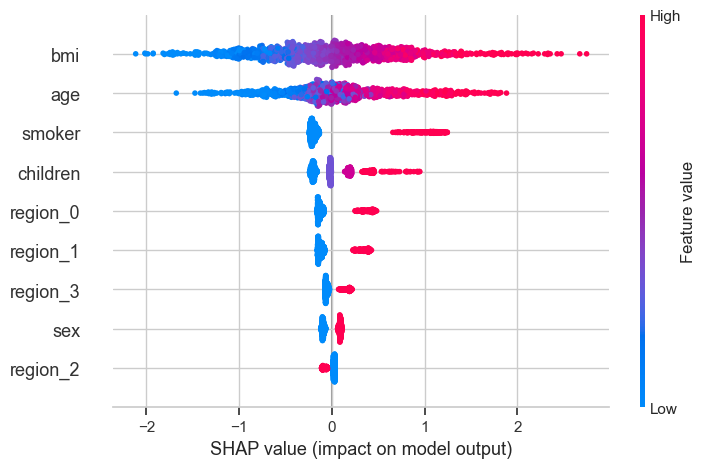

In [860]:
explainer = shap.Explainer(best_model, _X_train_df)
shap_values_train = explainer(_X_train_df)

shap.plots.beeswarm(shap_values_train, order=shap_values_train.abs.max(0))


**Primary Driver (Continuous): The customer's BMI. Higher BMI means significantly higher costs.**

**Primary Driver (Continuous): The customer's Age. Older age means higher costs.**

**Major Catalyst (Binary): Smoker Status. If the customer is a smoker, it triggers a massive increase in the predicted cost. This is the most powerful conditional factor.**

**The number of children has a small effect, and the customer's sex and region have negligible effects in this model.**

**The shape of the plots for age and bmi might look slightly different from both the linear and XGBoost models. The neural network uses its layers of weighted connections and activation functions to find its own non-linear representation of the data. The SHAP plot visualizes the result of this complex function.**

In [862]:
shap.force_plot(
    shap_values_train.base_values[10],   # the "expected value"
    shap_values_train.values[10],        # SHAP values for this instance
     _X_train_df.iloc[10, :],           # the feature values
    feature_names=_X_train_df.columns
)

ExactExplainer explainer: 1205it [01:06, 14.99it/s]                                                                    


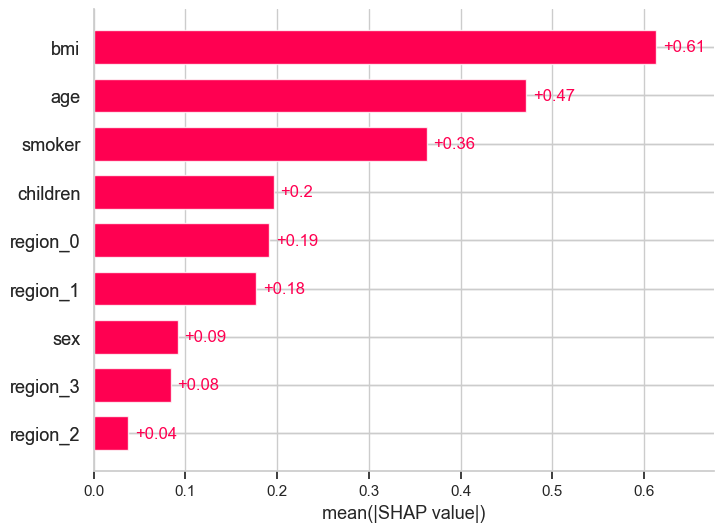

In [864]:
shap.plots.bar(explainer(_X_train_df))

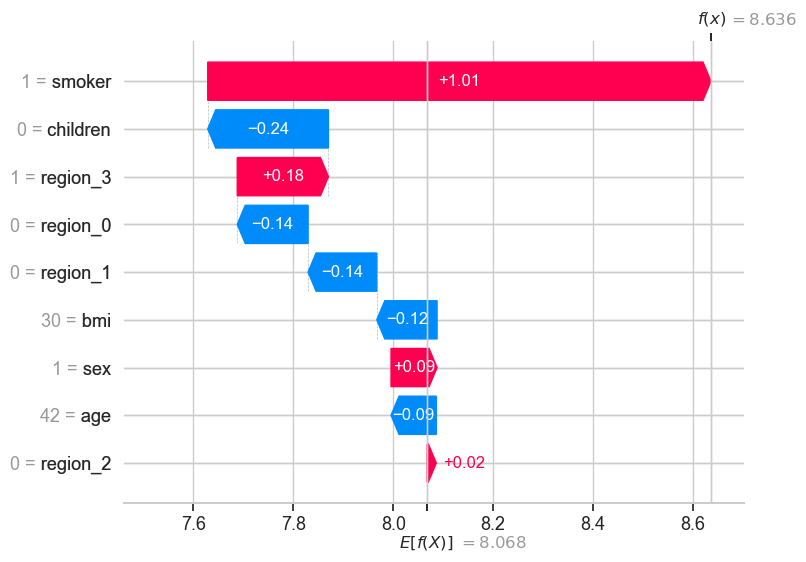

In [866]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values=shap_values_train[0])

# Summary

We chose to work with the [Medical Insurance Dataset](https://www.kaggle.com/datasets/mirichoi0218/insurance), which aims to predict insurance cost using 7 numerical & categorical features and a given ground truth (gt).

As we analyzed the data, we noticed that some of these features were crucially highly correlated with the target variable.

We divided the dataset into two splits:
* Training
* Test

The test split was kept unobserved by the model to mimic real-world scenarios.

We used several visualization and analysis methods in our pipeline, such as:

* Features Distribution (Pie & Histograms Charts) – Revealed an exponential distribution, which we smoothed using standartization.
* Pearson Correlation – Identified less correlated features.
* KDE Plots – Revealed distinct patterns in feature distributions.
* Outlier Distribution Analysis – Identified hard-outlier data points.

We trained a Linear Regression , xgboost and ANN models


# SHAP with Different Models
# 1. Linear Regression + SHAP

What SHAP shows here:
SHAP values for linear regression are straightforward because the model is additive and coefficients are interpretable.

Each SHAP bar/summary plot essentially mirrors the regression coefficients.

Positive SHAP values indicate features pushing the prediction up, negative values push it down.

The magnitude of SHAP values corresponds closely to the size of the regression coefficient (after scaling, if scaling was applied).

 **Interpretation:**

You’ll likely see features like age, bmi, smoking status (assuming this is an insurance dataset, which is common in SHAP demos) dominating the plot.

Linear regression assumes linear relationships, so SHAP here doesn’t capture non-linear effects, only direction and weight.

# 2. XGBoost + SHAP

What SHAP shows here:
XGBoost is a tree-based model, so SHAP uses TreeSHAP which efficiently calculates feature contributions.

SHAP summary plots will usually show more nuanced interactions.

Features might appear more important than in linear regression because trees can model splits and non-linearities.

Dependence plots for XGBoost often reveal thresholds (e.g., BMI above 30 sharply increasing charges).

**Interpretation:**

The SHAP values explain how each split contributes to the final prediction.

Unlike linear regression, XGBoost SHAP can show that a feature only matters strongly after a certain cutoff.

This often results in more accurate local explanations.

# 3. Artificial Neural Network (ANN) + SHAP

What SHAP shows here:
For ANNs, SHAP typically uses DeepSHAP (gradient + background reference data).

SHAP plots reflect the complex non-linear interactions learned by the network.

Importance rankings may differ significantly from linear regression or XGBoost, since the ANN may pick up higher-order interactions.

The force plots or waterfall plots can show how multiple features combine in a nonlinear way for an individual prediction.

 **Interpretation:**

SHAP explanations are less “direct” than in linear regression. A feature might not appear strongly globally but could have strong local importance.

Dependence plots often look smoother compared to XGBoost (since neural nets approximate functions continuously rather than stepwise splits).

# Differences in Interpretation

**Linear Regression:**

SHAP ≈ model coefficients.

Simple, globally consistent, but ignores interactions and nonlinear effects.

**XGBoost:**

SHAP captures non-linear feature thresholds and interactions from tree splits.

Local explanations are sharper, often showing cutoff effects.

**ANN:**

SHAP reveals smooth, nonlinear interactions.

More complex to interpret but can highlight hidden patterns that linear and tree models miss.

More sensitive to scaling (that’s why you noticed scaling applied in ANN SHAP but not XGBoost).
It was intriguing to explore and apply the concepts learned in class.
    